In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
from toolbox import *
from helpers import *
from proj1_helpers import *

# Just for testing, cannot be used in final submission
from sklearn import linear_model
import pandas as pd

### Pending tasks
1. Code review: least_squares, ridge_regression, gradient descent
2. Implement logistic regression
3. Preprocess data, construct better features
4. Implement cross validation
5. Prepare final submission code (Python script)
6. Report

## Load the training data into feature matrix, class labels, and event ids:

In [2]:
## Loading data
DATA_TRAIN_PATH = 'data/train.csv' 

## Summary of data
data = pd.read_csv(DATA_TRAIN_PATH)
print(len(data))
print(data.columns)
data.head(5)

250000
Index(['Id', 'Prediction', 'DER_mass_MMC', 'DER_mass_transverse_met_lep',
       'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet',
       'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt',
       'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality',
       'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi',
       'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi',
       'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt',
       'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt',
       'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt'],
      dtype='object')


,Id,Prediction,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,100000,s,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,...,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497
1,100001,b,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,...,-1.916,164.546,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226
2,100002,b,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,...,-2.186,260.414,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251
3,100003,b,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,...,0.060,86.062,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000
4,100004,b,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,...,-0.871,53.131,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000


In [ ]:
### Feature Engineering - Things to try
# 1. Performance measure: RMSE,AUC,log
# 2. Correlation
#    a. Find features correlated with output (each feature considered independently) (use histogram)
# 3. Evaluate goodness of each feature, Criteria such as Gini-index, Info-gain, Likelihood ratio
# 4. Reduce dimension: PCA 
# 5. Ridge regression/Lasso does automatic feature selection to some extent (since weights are constrained)
# 6. Decompose Categorical Attributes / Reframe Numerical Quantities
# 7. Try: Polynomial, log, exp, inverse

count    85667.000000
mean         0.320938
std          1.174793
min         -1.414000
25%         -1.275000
50%          0.994000
75%          1.349000
max          1.414000
Name: DER_met_phi_centrality, dtype: float64
count    164333.000000
mean         -0.362495
std           1.134813
min          -1.414000
25%          -1.381000
50%          -0.999000
75%           0.952000
max           1.414000
Name: DER_met_phi_centrality, dtype: float64


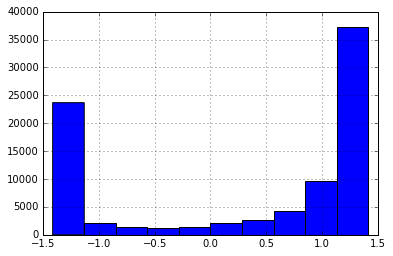

In [3]:
## Split the data based on two classes, useful to see the features separately
datas = data[data['Prediction']=='s']
datab = data[data['Prediction']=='b']
col = 'DER_met_phi_centrality'  ## Specify any feature
datas[col].hist()
print(datas[col].describe())
print(datab[col].describe())

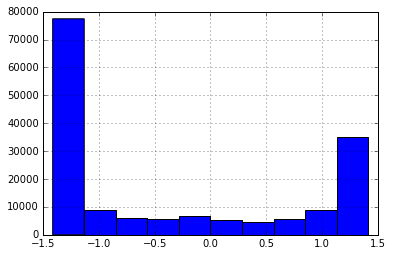

In [4]:
datab[col].hist()

In [101]:
### Based on observing histograms of each feature for the two classes [s,b], the following were 
### found to be most distinguishing, however results were worse than using all features.
#DER_mass_transverse_met_lep
#DER_pt_h
#DER_sum_pt
#DER_met_phi_centrality [+0.3,-0.3 means for two classes]
#PRI_tau_pt [46, 34 means] => slightly differernt
#PRI_met_sumet [233, 197 means]
#PRI_jet_num [1.18, 0.88]
#PRI_jet_all_pt [91, 63 means] 

## Select only the above features
data_features = data[['Id','Prediction','DER_mass_transverse_met_lep','DER_pt_h','DER_sum_pt','DER_met_phi_centrality','PRI_tau_pt','PRI_met_sumet','PRI_jet_num','PRI_jet_all_pt']].round(3)
#for col in data_features.columns[2:]:
#    data_features[col] = ((data_features[col] - np.mean(data_features[col]))/np.std(data_features[col]))
#    data_features[col] = data_features[col].round(3)

## Save the new dataset with only important features
#data_features.to_csv("data/train_metPhiCen.csv", index=False)


In [ ]:
### [TODO: Verify this part of the code]
## Replacing -999 with mean of the column
for col in data.columns[2:]:
    data.loc[data[col]==-999, col] = np.mean(data.loc[data[col]!=-999,col])
data.describe()
##data.to_csv("data/train_replace-999WithMean.csv", index=False)

## Standardise data
for col in data.columns[2:]:
    data[col] = ((data[col] - np.mean(data[col]))/np.std(data[col]))
    data[col] = data[col].round(3)
data.describe()
##data.to_csv("data/train_replace-999WithMean_standardised.csv", index=False)


## Do your thing crazy machine learning thing here :) ...

In [ ]:
## Loading data
### [TODO: Currently using original train.csv, we need to try with following options]
### 1. With only important features
### 2. Removing outliers
### 3. Replacing -999 with mean
### 4. Standardised data
### 5. With new features [polynomial, log, exp, 1/x... Also try interaction (new_feature=feature1*feature2)]

DATA_TRAIN_PATH = 'data/train.csv' 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

## Splitting into training and validation [TODO: Needs to be replaced with cross-validation]
train_x, val_x, train_y, val_y = split_data(tX, y, ratio=0.5, seed=1)

## Logistic regression [TODO: To be replaced with our implementation]
logistic = linear_model.LogisticRegression()
val_pred = logistic.fit(train_x, train_y).predict(val_x)   ## Train and then predict on validation data
print(sum(val_pred==val_y)/len(val_y))                     ## Accuaracy on Validation data

## Linear regression
mse, weights = least_squares(train_y, train_x)  ## [TODO: Verify code] [The current result on Kaggle uses this]
#mse, weights = least_squares_GD(train_y, train_x, gamma=0.1, max_iters=50)  ##[TODO: Verify code]
#mse, weights = ridge_regression(train_y, train_x, 0.01)    ##[TODO: Verify code]

val_pred = predict_labels(weights, val_x)  ## Predict on validation data
print(sum(val_pred==val_y)/len(val_y))     ## Accuaracy on Validation data


## Generate predictions and save ouput in csv format for submission:

In [23]:
DATA_TEST_PATH = 'data/test.csv'  
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [24]:
OUTPUT_PATH = 'data/test_sub' ## [Submission file name]
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

In [ ]:
sum(y_pred == 1)/len(y_pred)  ## Number of ones predicted, quick check to make sure that its not all 1s or -1s
#sum(y == 1)/len(y)